In [1]:
# Load Relevant Modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import xarray as xr
import sys
from tqdm.notebook import tqdm

In [2]:
# Define the BSP function that is called and recursively subdivides a 2D distribution

def binary_space_partition(x, y, z, v, c, a, depth: int, axis: int = 0):
    """
    Create a binary space partition tree from a set of point coordinates
    
    >>> binary_space_partition(numpy.array([1,2,4,2]),
    ...                        numpy.array([3,4,8,1]), 
    ...                        depth=1)
    ([1, 4, 1, 8], (([1, 2, 3, 4], None), ([2, 4, 1, 8], None)))
    
    Args:
        x: x coordinates
        y: y coordinates
        v: distribution data
        z, c, a: variables of interest to save in BSP tree
        depth: maximum tree depth
        axis: initial branch axis
        
    Returns:
        A tuple (bounds, (left, right)) where bounds is the bounding
        box of the contained points and left and right are the results
        of calling binary_space_partition on the left and right tree
        branches. Once the tree has reached 'depth' levels then the
        second element will be None
    """
    
    bounds = (x.min(), x.max(), y.min(), y.max())
    
    # Calculate diagnostic for this partition
    vsum = v.sum()
    csum = c.sum()
    asum = a.sum()
    ymean = (y*c).sum()/csum
    xmean = (x*c).sum()/csum
    zmean = (z*c).sum()/csum
    
    if depth == 0 or x.size <= 2:
        # Add diagnostic to  the output
        return [bounds, xmean, ymean, zmean, vsum, csum,  asum, None]
    
    # Sort coordinates along axis
    if axis == 0:
        idx = np.argsort(x)
    elif axis == 1:
        idx = np.argsort(y)
    else:
        raise ArgumentError
    
    # Indexes for left and right branches
    # Use volume on current branch to find the split at the centre point in volume
    vtot_half = v.sum()/2.
    v1 = v[idx].cumsum()
    
    idx_l = idx[v1<vtot_half]
    idx_r = idx[v1>vtot_half]
    
    # Recurse into the branches
    left = binary_space_partition(x[idx_l], y[idx_l], z[idx_l], v[idx_l], c[idx_l], a[idx_l], depth-1, (axis+1)%2)  
    right = binary_space_partition(x[idx_r], y[idx_r], z[idx_r], v[idx_r], c[idx_r], a[idx_r], depth-1, (axis+1)%2)

    return [left, right]

In [3]:
chunks = {'time': 1}
RR_NEMO = 106/16

NEMO_historical_tracers = xr.open_mfdataset('C:/users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/*carbon*.nc',decode_times=True, chunks = chunks,combine='nested',concat_dim='time')
NEMO_historical_TS = xr.open_mfdataset('C:/users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/*phys*.nc',decode_times=True, chunks = chunks,combine='nested',concat_dim='time')

NEMO_mask = xr.open_mfdataset('C:/users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/mask_NEMO.nc',decode_times=True, chunks = chunks)
NEMO_mask_renamed = NEMO_mask.rename_dims(dict(j='x', i='y', lev='deptht'))\
.rename(dict(lev='deptht', lon='nav_lon', lat='nav_lat'))

In [4]:
NEMO_C_star = NEMO_historical_tracers.Cstar
NEMO_land_mask = (NEMO_C_star/NEMO_C_star)
NEMO_area = NEMO_historical_tracers.cell_area*NEMO_land_mask.isel(deptht=0)
NEMO_depth = NEMO_historical_tracers.deptht.values
dArea_3D = NEMO_area.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth).values
dSArea_3D = NEMO_area.expand_dims({'deptht':NEMO_depth.size},axis=1).assign_coords(deptht=NEMO_depth)
NEMO_volume = dArea_3D*NEMO_historical_TS.e3t
# dSArea_3D[:,1:,:,:] = 0


In [5]:
NEMO_mask_4D = NEMO_mask_renamed.expand_dims({'time':NEMO_historical_tracers.time.size},axis=1)\
.assign_coords(time=NEMO_historical_tracers.time)
Basins = NEMO_mask.Basins.values

In [6]:
## Flatten Volume, Salinity and Temp (becomes 6000x5400000 array) 
volcello_flattened = (NEMO_volume.stack(z=("y", "x", "deptht")))
bigthetao_flattened = (NEMO_historical_TS.votemper.stack(z=("y", "x", "deptht")))
so_flattened = (NEMO_historical_TS.vosaline.stack(z=("y", "x", "deptht")))
C_star_flattened = (NEMO_C_star.stack(z=("y", "x", "deptht")))
areacello_flattened = (dSArea_3D.stack(z=("y", "x", "deptht")))
mask_flattened = (NEMO_mask_4D.mask_NEMO.stack(z=("y", "x", "deptht")))

BA = mask_flattened
V = volcello_flattened
S = ((so_flattened))
T = ((bigthetao_flattened))
C_star = C_star_flattened
A = (areacello_flattened)
N = A.shape[1] 

depth=7
window = 2
# print(sys.argv[1])
ti = 0 #int(sys.argv[1])

weights = [31,28.25,31,30,31,30,31,31,30,31,30,31]
months = np.nancumsum(weights)/np.sum(weights)
months_repeating = np.tile(months, int(window/12))

In [7]:
# %%time
partitions_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth, 4))
T_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
S_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
C_star_mean_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
V_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
A_sum_hist = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
A_sum_hist_reg = np.zeros((NEMO_mask_renamed.Basins.size, window,2**depth))
time_array = np.zeros(window)
for i in tqdm(range(ti*window, (ti+1)*window)):
    time_array[int(i-ti*window)] = i
    for j in tqdm(range(Basins.size)):
        # Get a single timestep as numpy, not dask
        x = S[i,:].values
        y = T[i,:].values
        z = C_star[i,:].values
        v = A[i,:].values
        c = V[0,:].values*BA[j,i,:].values
        a = A[i,:].values*BA[j,i,:].values
        
        # Clean out NAN values
        idx = np.isfinite(x)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]

        idx = np.isfinite(y)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]
        
        idx = np.isfinite(z)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]

        idx = np.isfinite(v)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]

        idx = np.isfinite(c)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]

        idx = np.isfinite(a)
        x = x[idx]
        y = y[idx]
        z = z[idx]
        v = v[idx]
        c = c[idx]
        a = a[idx]

        b_results = binary_space_partition(x,y,z,v,c,a, depth=depth, axis=1)

        bsp_flat = list(itertools.chain(*b_results))
        while (len(bsp_flat) <= 2**depth):
            bsp_flat = list(itertools.chain(*bsp_flat))
        partitions_hist[j,int(i-ti*window),:,:] = np.array(bsp_flat[::8])
        T_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[1::8])
        S_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[2::8])
        C_star_mean_hist[j,int(i-ti*window),:] = np.array(bsp_flat[3::8])
        A_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[4::8])
        V_sum_hist[j,int(i-ti*window),:] = np.array(bsp_flat[5::8])
        A_sum_hist_reg[j,int(i-ti*window),:] = np.array(bsp_flat[6::8])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-2-1603c5591416>:33: RuntimeWarning: invalid value encountered in double_scalars
  ymean = (y*c).sum()/csum
<ipython-input-2-1603c5591416>:34: RuntimeWarning: invalid value encountered in double_scalars
  xmean = (x*c).sum()/csum
<ipython-input-2-1603c5591416>:35: RuntimeWarning: invalid value encountered in double_scalars
  zmean = (z*c).sum()/csum


  0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
da_partitions_hist = xr.DataArray(data = partitions_hist, dims = ["Basin","Time", "Depth", "Coords"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth= np.arange(2**depth), Coords = np.arange(4)),
                        attrs=dict(description="[x0,y0,xmax,ymax] bounds of BSP framework", variable_id="Partitions"))
da_S_mean_hist = xr.DataArray(data = S_mean_hist, dims = ["Basin", "Time", "Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean Salinity", units="g/kg", variable_id="S"))
da_T_mean_hist = xr.DataArray(data = T_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean Temperature", units="K", variable_id="T"))
da_C_star_mean_hist = xr.DataArray(data = C_star_mean_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Mean C_star", units="mmol-C/m3", variable_id="C_star"))

da_A_sum_hist = xr.DataArray(data = A_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Area", units="m^2", variable_id="EN4 A_sum"))
da_V_sum_hist = xr.DataArray(data = V_sum_hist, dims = ["Basin", "Time","Depth"], 
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Volume", units="m^3", variable_id="Basin V_sum"))
da_A_sum_hist_reg = xr.DataArray(data = A_sum_hist_reg, dims = ["Basin", "Time","Depth"],
                           coords=dict(Basin = Basins, Time = time_array, Depth=np.arange(2**depth)),
                        attrs=dict(description="Total Area", units="m^2", variable_id="Basin A_sum"))

ds_BSP = xr.Dataset()
ds_BSP['Partitions_hist'] = da_partitions_hist
ds_BSP['T_mean_hist'] = da_T_mean_hist
ds_BSP['S_mean_hist'] = da_S_mean_hist
ds_BSP['C_star_mean_hist'] = da_C_star_mean_hist
ds_BSP['V_sum_hist'] = da_V_sum_hist
ds_BSP['A_sum_hist'] = da_A_sum_hist_reg

ds_BSP.to_netcdf('C:/users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/BSP_NEMO_TS_hist_area_%i_%i.nc' %(ti*window, (ti+1)*window-1))

In [9]:
print(np.nansum((NEMO_volume*NEMO_historical_TS.votemper).isel(time=0).values))
print(da_V_sum_hist.isel(Time=0).values.sum())
print('-------')
print(np.nansum((NEMO_volume*NEMO_historical_TS.votemper).isel(time=1).values))
print(da_V_sum_hist.isel(Time=1).values.sum())

4.859335108925239e+18
1.3406299615078497e+18
-------
4.864515298908427e+18
1.3406299615078497e+18


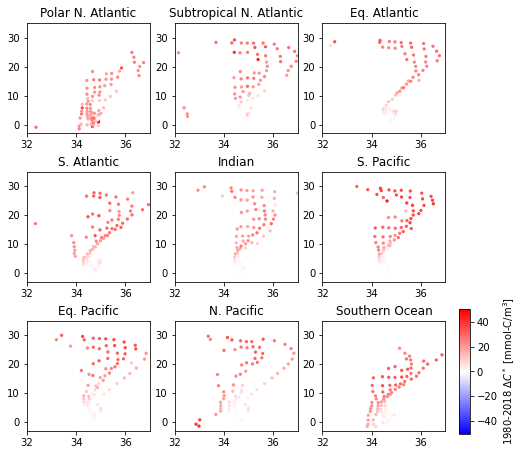

In [10]:
fig, axs = plt.subplots(3,3, figsize=(15*0.5,15*0.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .35, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

for i in range(Basins.size):
    axs[i].scatter(da_T_mean_hist[i,1,:].values, da_S_mean_hist[i,1,:].values, 5,\
                da_C_star_mean_hist[i,1,:]-da_C_star_mean_hist[i,0,:], cmap=plt.cm.bwr, vmin=-50, vmax=50)
    axs[i].set_title(Basins[i])
    axs[i].set_xlim(32,37)
    axs[i].set_ylim(-3,35)
    
m = plt.cm.ScalarMappable(cmap=plt.cm.bwr)
m.set_clim(-50, 50)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('1980-2018 $\Delta C^*$ [mmol-C/m$^3$]') 
# plt.savefig('/g/data/e14/txs156/Figures/BSP_C_star_CARBO_MM.png', dpi=300, bbox_inches='tight')
plt.show()

1.3406299615078497e+18
3.2814324102683336e+16


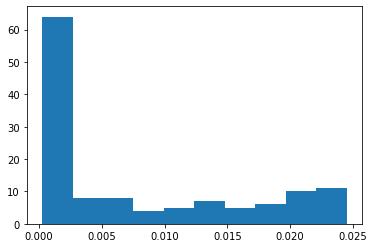

1.3406299615078497e+18
0.0


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  4., 15., 12., 11., 16.,  9.,
         4.,  8.,  8., 14., 26.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([11.        , 11.17948718, 11.35897436, 11.53846154, 11.71794872,
        11.8974359 , 12.07692308, 12.25641026, 12.43589744, 12.61538462,
        12.79487179, 12.97435897, 13.15384615, 13.33333333, 13.51282051,
        13.69230769, 13.87179487, 14.05128205, 14.23076923, 14.41025641,
        14.58974359, 14.76923077, 14.94871795, 15.12820513, 15.30769231,
        15.48717949, 15.66666667, 15.84615385, 16.02564103, 16.20512821,
        16.38461538, 16.56410256, 16.74358974, 16.92307692, 17.1025641 ,
        17.28205128, 17.46153846, 17.64102564, 17.82051282, 18.        ]),
 <BarContainer object of 39 artists>)

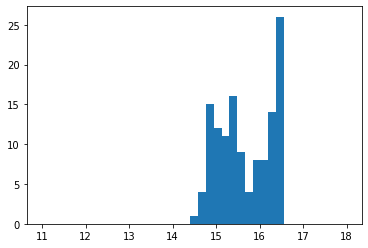

In [11]:
Vearly = da_V_sum_hist.isel(Time=0)
Vlate = da_V_sum_hist.isel(Time=-1)


print(Vearly.sum().values)
print(np.nanmax(np.nansum(Vearly.values,axis=0)))
plt.hist(1/(Vearly.sum().values/(np.nansum(Vearly.values,axis=0))))
plt.show()

print(Vlate.sum().values)
print(Vearly.sum().values-Vlate.sum().values)
plt.hist(np.log10(np.nansum(Vearly.values,axis=0)), bins=np.linspace(11,18,40))